In [7]:
import numpy as np
import pandas as pd

df = pd.read_csv('fraudTest.csv')
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

Loading dataset...
Dataset shape: (555719, 23)

First few rows:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2020-06-21 12:14:25  2291163933867244   
1           1   2020-06-21 12:14:33  3573030041201292   
2           2   2020-06-21 12:14:53  3598215285024754   
3           3   2020-06-21 12:15:15  3591919803438423   
4           4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street  ...      lat      long  \
0   Elliott      M            351 Darlene Green  ...  33.9659  -80.9355  

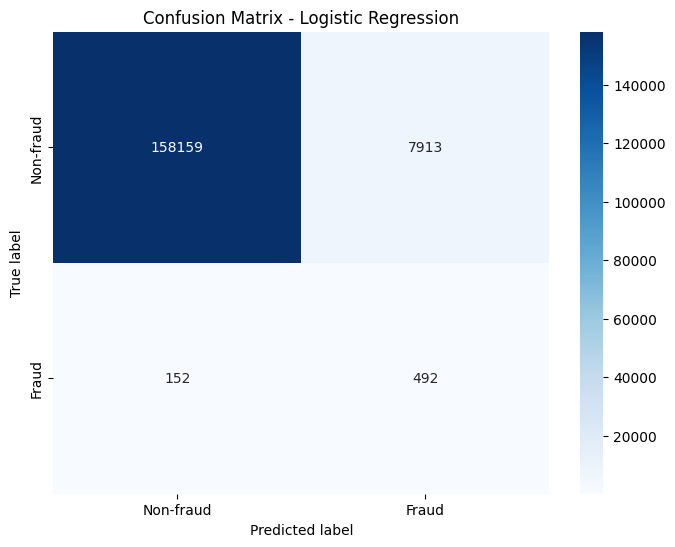

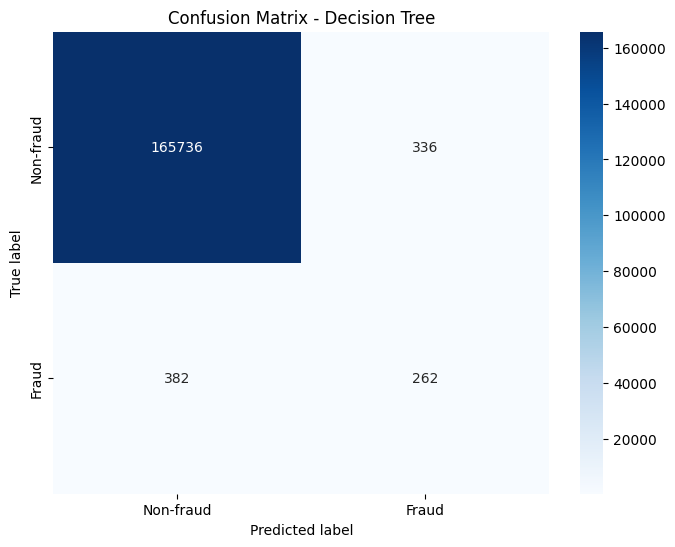

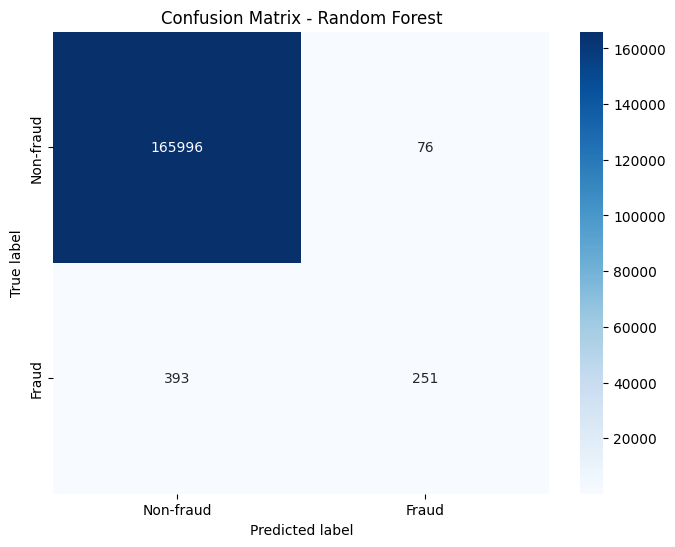

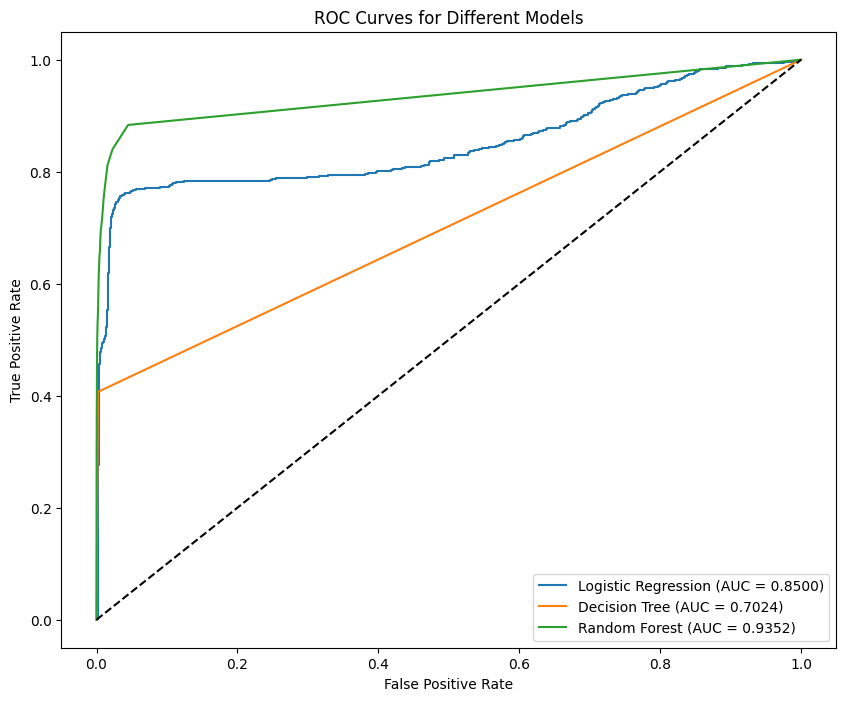

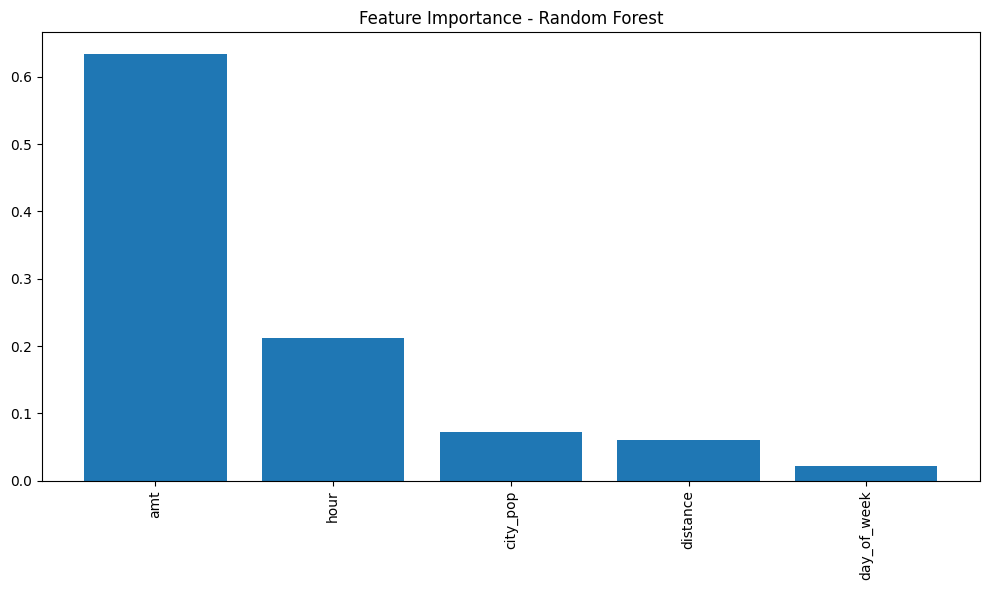

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 1. Load the dataset
print("Loading dataset...")
df = pd.read_csv('fraudTest.csv')
print(f"Dataset shape: {df.shape}")

# 2. Basic Data Exploration
print("\nFirst few rows:")
print(df.head())

print("\nClass distribution:")
print(df['is_fraud'].value_counts())
print(f"Fraud percentage: {df['is_fraud'].mean() * 100:.2f}%")

# 3. Feature Selection
# Select numerical features that are relevant for fraud detection
numerical_features = ['amt']

# Add geographical features if available
if all(col in df.columns for col in ['lat', 'long', 'merch_lat', 'merch_long']):
    # Calculate distance between customer and merchant
    from math import radians, cos, sin, asin, sqrt

    def haversine(lat1, lon1, lat2, lon2):
        # Convert decimal degrees to radians
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        # Radius of earth in kilometers is 6371
        km = 6371 * c
        return km

    # Apply the function to create a new feature
    df['distance'] = df.apply(
        lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']),
        axis=1
    )
    numerical_features.append('distance')

# Add time-based features if available
if 'trans_date_trans_time' in df.columns:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    numerical_features.extend(['hour', 'day_of_week'])

# Add demographic features if available
if 'city_pop' in df.columns:
    numerical_features.append('city_pop')

print(f"\nSelected features for modeling: {numerical_features}")

# 4. Data Preprocessing
X = df[numerical_features]
y = df['is_fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Handle class imbalance


# 6. Model Training and Evaluation
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
}

# Dictionary to store results
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate probabilities for ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.decision_function(X_test_scaled)

    # Evaluate the model
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-fraud', 'Fraud'],
                yticklabels=['Non-fraud', 'Fraud'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    results[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

    print(f"AUC Score: {roc_auc:.4f}")

# 7. Compare models using ROC curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["auc"]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.savefig('roc_comparison.png')

# 8. Find the best model based on AUC
best_model_name = max(results.items(), key=lambda x: x[1]['auc'])[0]
print(f"\nBest performing model: {best_model_name} with AUC = {results[best_model_name]['auc']:.4f}")

# 9. Feature importance (if applicable)
if best_model_name in ['Decision Tree', 'Random Forest']:
    best_model = models[best_model_name]
    feature_importance = best_model.feature_importances_

    # Sort feature importance
    indices = np.argsort(feature_importance)[::-1]

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importance - {best_model_name}')
    plt.bar(range(X_train.shape[1]), feature_importance[indices], align='center')
    plt.xticks(range(X_train.shape[1]), [numerical_features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig('feature_importance.png')

    print("\nFeature Importance:")
    for i in indices:
        print(f"{numerical_features[i]}: {feature_importance[i]:.4f}")

print("\nCredit Card Fraud Detection Project Completed!")